In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import json
from torch.utils.data import Dataset, DataLoader

import sys
sys.path.append('/home/billault/ml_design2/decoder/')
sys.path.append('/home/billault/ml_design2/encoder/')
from encoder_models import *
from dataloader_encoder import encoder_dataset
from decoder_models import *
# import pandas as pd
import copy
import h5py
import datetime

import glob
import warnings
warnings.filterwarnings("ignore")


In [7]:

# import argparse
# parser = argparse.ArgumentParser(description='Implement pipeline')
# parser.add_argument('config_path', type=str)
# parser.add_argument('--dataset_path', type = str, default='datasets/dataset_ex.h5')
# parser.add_argument('--noise_mask_path', type = str, default='datasets/noise_mask.npy')
# parser.add_argument('--decode', type = int, default=0)
# parser.add_argument('--plot_latent', type = int, default=0)
# args = parser.parse_args()

config_path = '/ltenas8/users/anneclaire/retrieval_202306/encoder/encoder_runs_20230629_2/Encoder6_Resblock/config_encoder.json'
dataset_path = 'datasets/ds_selected_events_new_noise.h5'
# noise_mask = np.load(args.noise_mask_path)
decode = 1
plot_latent = 1


In [ ]:

#############################################################################################################
### LOAD MODEL
#############################################################################################################

config = json.load(open(config_path))

encoder_name = config['encoder_name']
nb_channels_enc = config['nb_channels_enc']

encoder = locals()[encoder_name](nb_channels_enc)

checkpoint_name = config['directory']+'/checkpoint.pth'
checkpoint = torch.load(checkpoint_name,map_location=torch.device('cpu'))
encoder.load_state_dict(checkpoint['model_state'])
encoder.eval()

config_decW = json.load(open(config['config_W_decoder'])) # we just need to load one of the decoder config files for now
mean_normalization_spec_json = config_decW['normalize_path']+'/means_spec.json'
std_normalization_spec_json = config_decW['normalize_path']+'/stds_spec.json'
mean_normalization_latent_npy = config_decW['normalize_path']+'/means_input.npy'
std_normalization_latent_npy = config_decW['normalize_path']+'/stds_input.npy'



#############################################################################################################
### LOAD DATASET
#############################################################################################################
print('LOAD DATASET')
file_spec = dataset_path.split('/')[-1].split('.')[0]
f = h5py.File(dataset_path)
rg = f['range_gates'][:]
t = f['time'][:]
dt = [datetime.datetime.utcfromtimestamp(tt) for tt in t]

dataset = encoder_dataset(dataset_path,rgate_start = config['rgate_start'], rgate_end = config['rgate_end'], batch_shape=200,step_for_data_augmentation =-1,mean_normalization_json = mean_normalization_spec_json, std_normalization_json = std_normalization_spec_json) 




#############################################################################################################
### IMPLEMENT MODEL ON DATASET
#############################################################################################################
print('IMPLEMENT MODEL ON DATASET')
itstart = 350
itend = 1700

with torch.no_grad():
    ex = dataset[itstart:itend]
    l = encoder.cpu().encode(ex)
# We select the indices of the latent variables to be used in the X, Ka and W emulators.    
l_x = l[:,:,:,config['inds_latent_vars_X']]
l_ka = l[:,:,:,config['inds_latent_vars_Ka']]
l_w = l[:,:,:,config['inds_latent_vars_W']]



In [25]:

#############################################################################################################
### EXTRACT LATENT VARIABLES
#############################################################################################################
print('EXTRACT LATENT VARIABLES')
mean_latent = np.load(mean_normalization_latent_npy)
std_latent = np.load(std_normalization_latent_npy)
latent_denorm = l.detach().numpy()*std_latent+mean_latent

latent_variables = config_decW['input_variables']
parameters_full = {
    latent_variables[i]:latent_denorm[:,0,:,i] for i in range(len(latent_variables))
    }

for features in config_decW['features_to_log']:
    parameters_full[features] = np.exp(parameters_full[features])



EXTRACT LATENT VARIABLES


In [ ]:

#############################################################################################################
### COMPUTE RADAR MOMENTS (FOR REFERENCE)
#############################################################################################################
print('COMPUTE RADAR MOMENTS')
sX = f['sX'][:]
sKa = f['sKa'][:]
sW = f['sW'][:]

sX_lin = 10**(sX/10)
sKa_lin = 10**(sKa/10)
sW_lin = 10**(sW/10)
vel = f['vel'][:]
dv = vel[1]-vel[0]
ZeX = 10*np.log10(np.sum(sX_lin*dv, axis=2))
ZeKa = 10*np.log10(np.sum(sKa_lin*dv, axis=2))
ZeW = 10*np.log10(np.sum(sW_lin*dv, axis=2))
plt.pcolormesh(ZeX[itstart:itend,config['rgate_start']:config['rgate_end']].T, vmin=-40, vmax=20, cmap='turbo')
plt.colorbar()

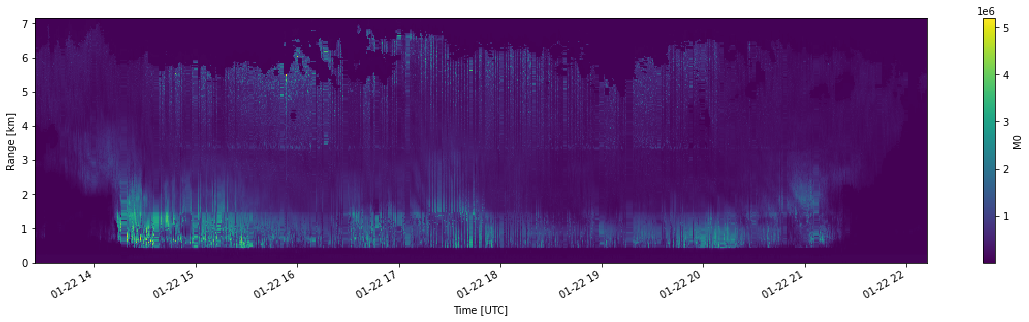

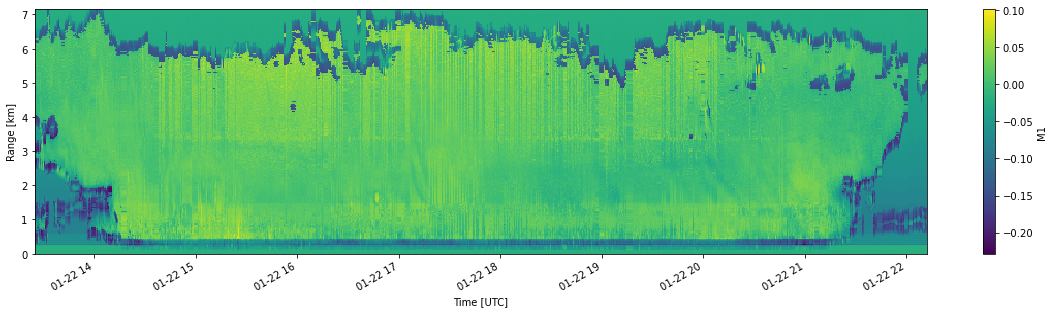

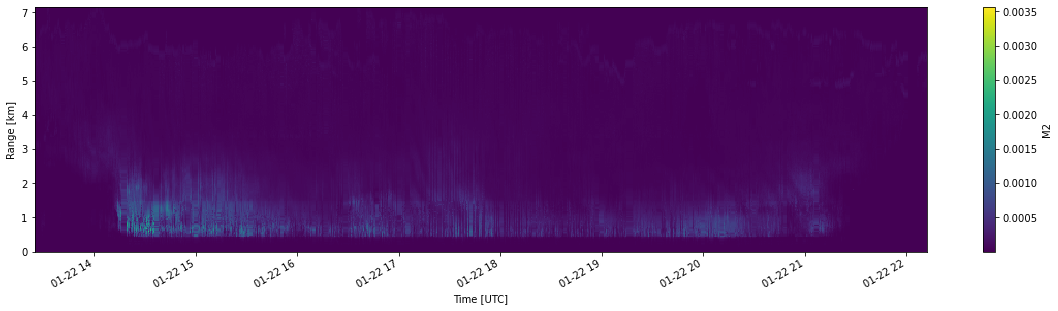

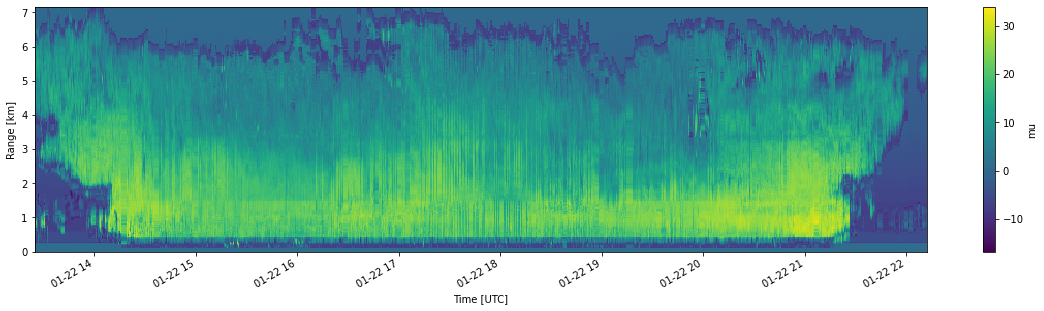

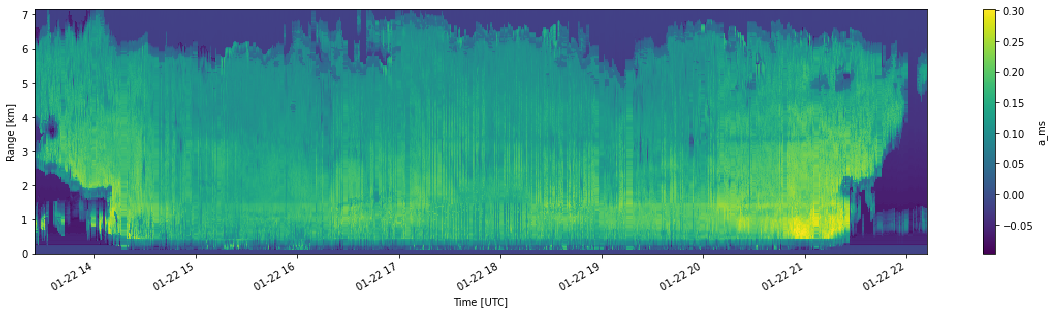

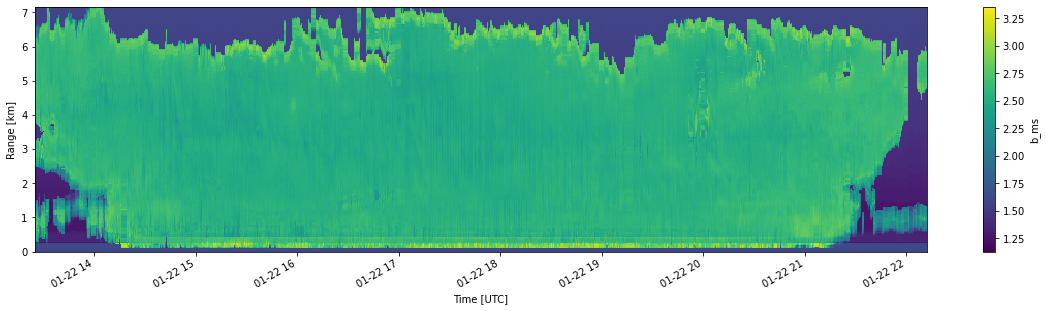

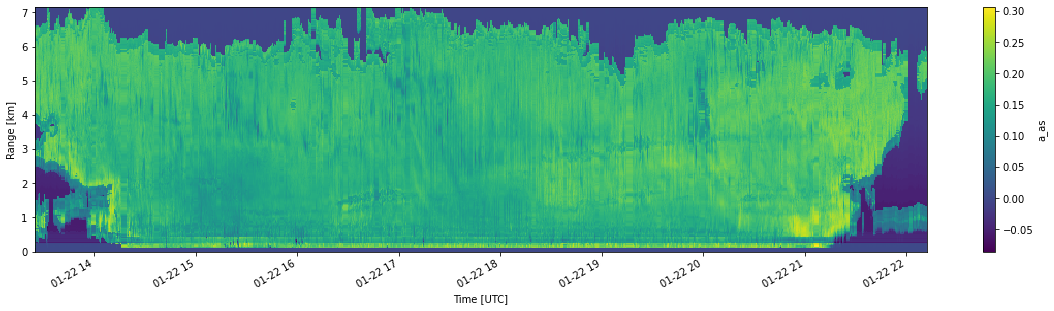

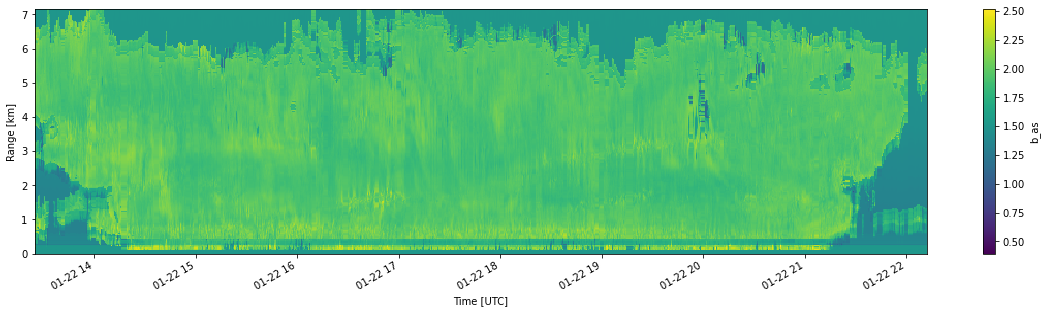

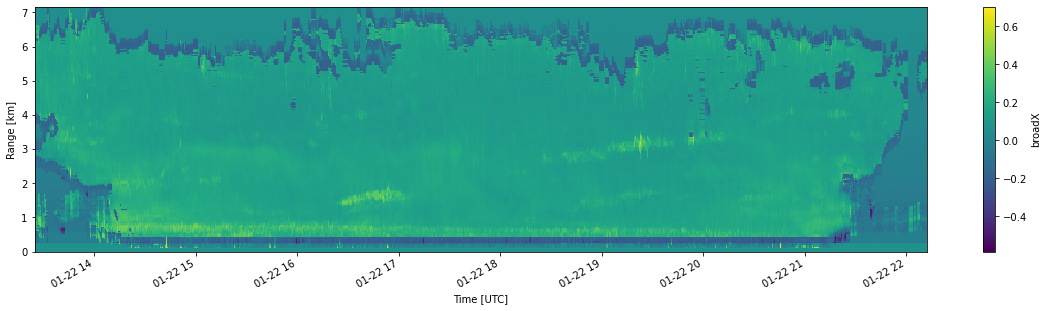

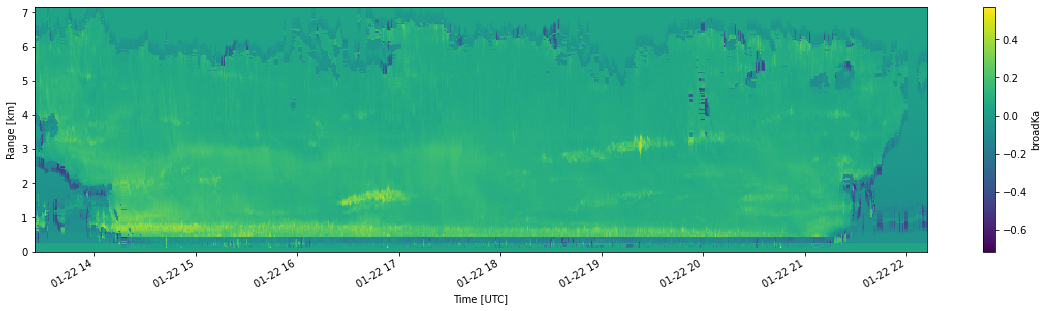

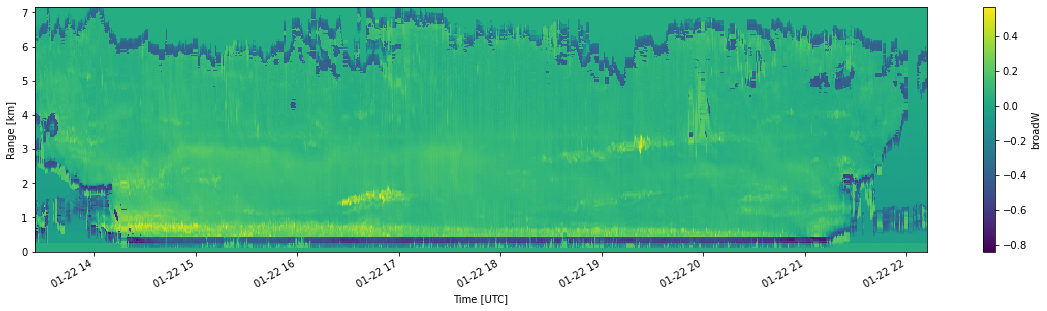

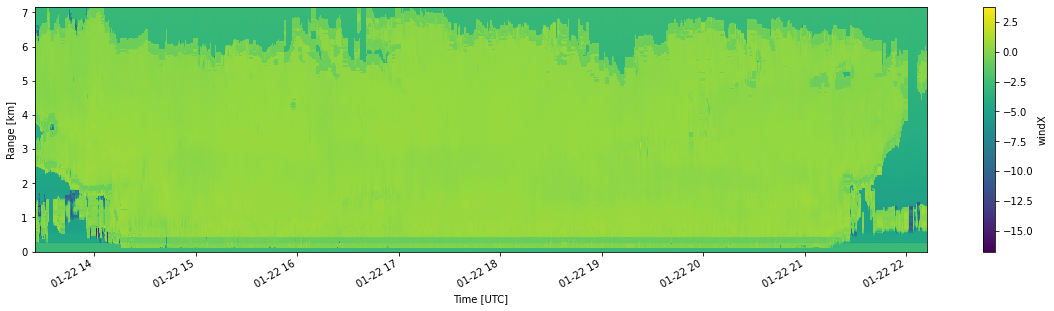

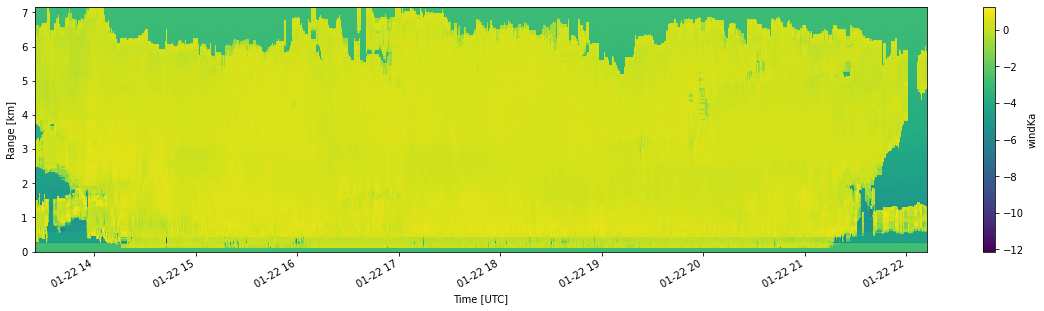

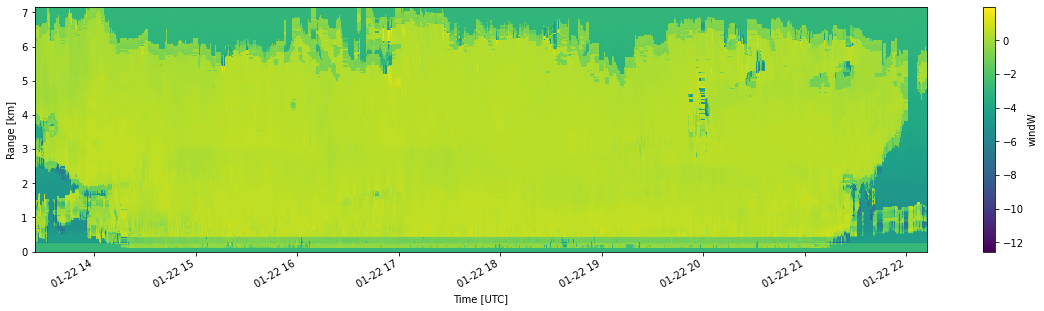

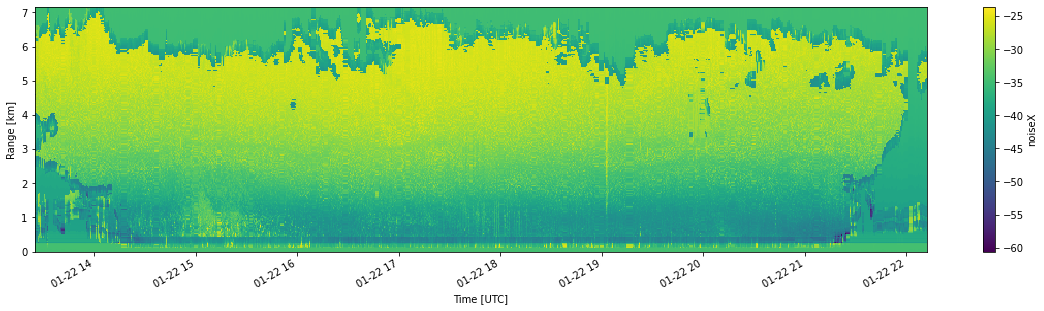

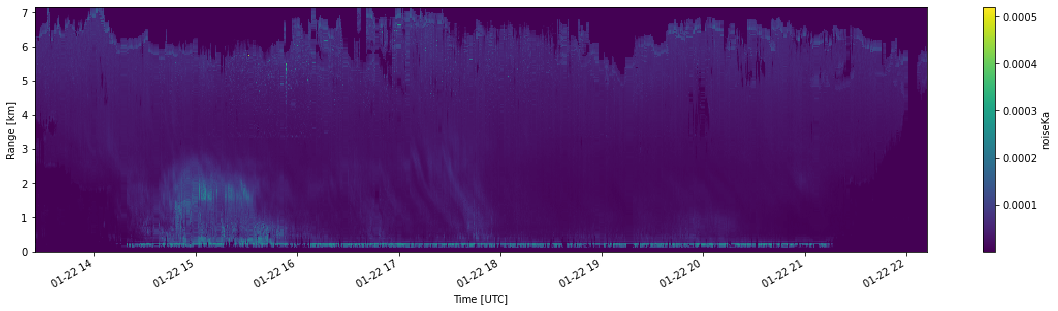

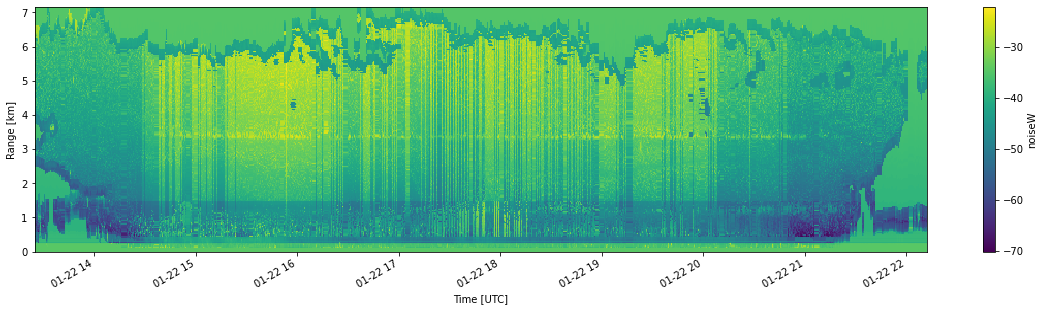

In [23]:
#############################################################################################################
### PLOT LATENT VARIABLES (MICROPHYSICS + ATMOSPHERIC ETC)
#############################################################################################################
for latent_var in parameters_full.keys():
    fig = plt.figure(figsize=(20,5))
    var2plot = parameters_full[latent_var]
    plt.pcolormesh(dt[itstart:itend],rg[config['rgate_start']:config['rgate_end']]/1e3,var2plot[:].T,vmin=np.nanmin(var2plot), vmax = np.nanmax(var2plot))
    plt.colorbar(label = latent_var)
    plt.xlabel('Time [UTC]')
    plt.ylabel('Range [km]')
    fig.autofmt_xdate()
    # fig.savefig(config['directory']+'/latent_'+latent_var+'_'+filespec,bbox_inches='tight', dpi=200,facecolor='w')


In [28]:
# #############################################################################################################
# ### DECODE (RECONSTRUCT SPECTROGRAMS)
# #############################################################################################################

print('DECODE (RECONSTRUCT SPECTROGRAMS)')

model_name_decW=config_decW['model_name']
nb_channels_decW, n_hidden_units_decW, n_input_features_decW = config_decW['n_channels'], config_decW['n_hidden_layers'],config_decW['n_input_features']
checkpoint_decW = torch.load(config_decW['directory']+config_decW['checkpoint_name'],map_location=torch.device('cpu'))
model_W_state_dict = checkpoint_decW['model_state']

config_decX = json.load(open(config['config_X_decoder']))
model_name_decX=config_decX['model_name']
checkpoint_decX = torch.load(config_decX['directory']+config_decX['checkpoint_name'],map_location=torch.device('cpu'))
model_X_state_dict = checkpoint_decX['model_state']
nb_channels_decX, n_hidden_units_decX, n_input_features_decX = config_decX['n_channels'], config_decX['n_hidden_layers'],config_decX['n_input_features']

config_decKa = json.load(open(config['config_Ka_decoder']))
model_name_decKa=config_decKa['model_name']
checkpoint_decKa = torch.load(config_decKa['directory']+config_decKa['checkpoint_name'],map_location=torch.device('cpu'))
model_Ka_state_dict = checkpoint_decKa['model_state']
nb_channels_decKa, n_hidden_units_decKa, n_input_features_decKa = config_decKa['n_channels'], config_decKa['n_hidden_layers'],config_decKa['n_input_features']


decoderX = locals()[model_name_decX](nb_channels_decX, n_hidden_units_decX, n_input_features_decX)
decoderX.load_state_dict(model_X_state_dict)
decoderKa = locals()[model_name_decKa](nb_channels_decKa, n_hidden_units_decKa, n_input_features_decKa)
decoderKa.load_state_dict(model_Ka_state_dict)
decoderW = locals()[model_name_decW](nb_channels_decW, n_hidden_units_decW, n_input_features_decW)
decoderW.load_state_dict(model_W_state_dict)

decoderX.eval()
decoderKa.eval()
decoderW.eval()

with torch.no_grad():
    ox = decoderX.cpu().decode(l_x.view((-1,n_input_features_decX)))[:,0,:].view(ex[:,0,:,:].shape)
    oka = decoderKa.cpu().decode(l_ka.view((-1,n_input_features_decKa)))[:,0,:].view(ex[:,1,:,:].shape)
    ow = decoderW.cpu().decode(l_w.view((-1,n_input_features_decW)))[:,0,:].view(ex[:,2,:,:].shape)



DECODE (RECONSTRUCT SPECTROGRAMS)


In [29]:

mean_normalization_json = config_decW['normalize_path']+'/means_spec.json'
std_normalization_json = config_decW['normalize_path']+'/stds_spec.json'
mean_norm_X = json.load(open(mean_normalization_json))['specX']
mean_norm_Ka = json.load(open(mean_normalization_json))['specKa']
mean_norm_W = json.load(open(mean_normalization_json))['specW']
std_norm_X = json.load(open(std_normalization_json))['specX']
std_norm_Ka = json.load(open(std_normalization_json))['specKa']
std_norm_W = json.load(open(std_normalization_json))['specW']

print('renormalizing')
ex = ex.cpu()
tx = ex[:,0]*std_norm_X+mean_norm_X
tka = ex[:,1]*std_norm_Ka+mean_norm_Ka
tw = ex[:,2]*std_norm_W+mean_norm_W
ox = ox*std_norm_X+mean_norm_X
oka = oka*std_norm_Ka+mean_norm_Ka
ow = ow*std_norm_W+mean_norm_W
ox = ox.cpu().detach()
oka = oka.cpu().detach()
ow = ow.cpu().detach()



renormalizing


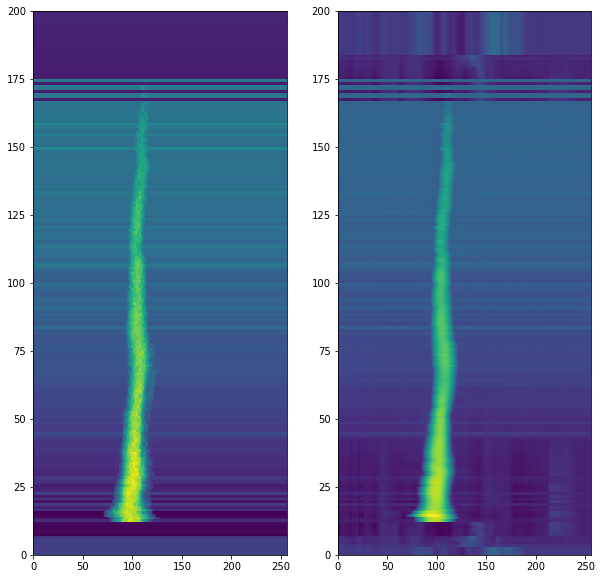

In [35]:
fig,axs=plt.subplots(1,2,figsize=(10,10))
axs[0].pcolormesh(tx[700])
axs[1].pcolormesh(ox[700])
fig.savefig('example_X.png',bbox_inches='tight', dpi=200,facecolor='w')

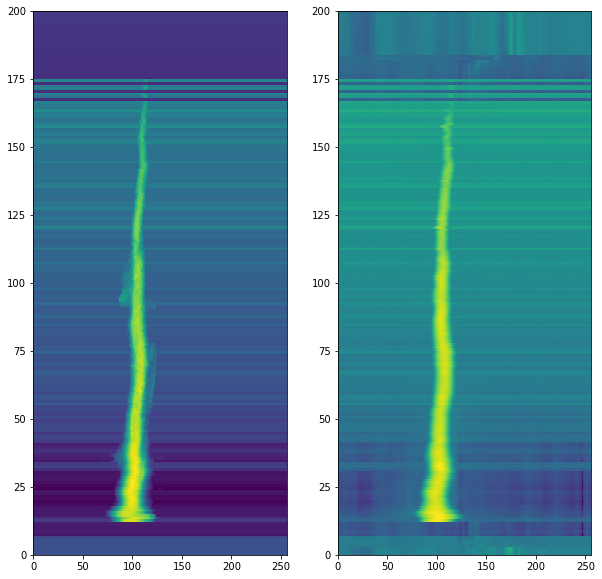

In [34]:
fig,axs=plt.subplots(1,2,figsize=(10,10))
axs[0].pcolormesh(tw[700])
axs[1].pcolormesh(ow[700])
fig.savefig('example_W.png',bbox_inches='tight', dpi=200,facecolor='w')

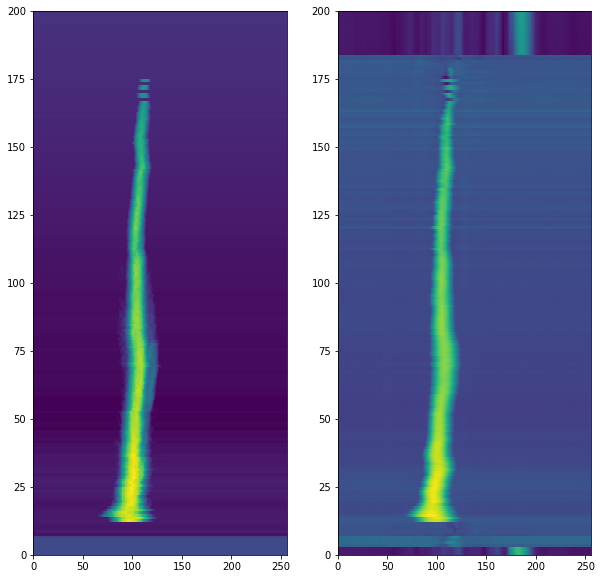

In [33]:
fig,axs=plt.subplots(1,2,figsize=(10,10))
axs[0].pcolormesh(tka[700])
axs[1].pcolormesh(oka[700])
fig.savefig('example_Ka.png',dpi=200,bbox_inches='tight',facecolor='w')

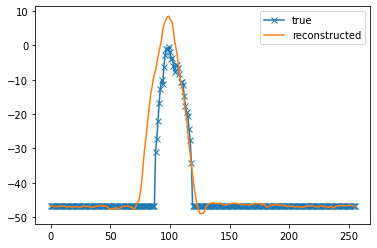

In [86]:
plt.plot(tx[700,65,:],'-x',label='true')
plt.plot(ox[700,65,:],label='reconstructed')
plt.legend()
plt.savefig('example_X_singlespec.png')

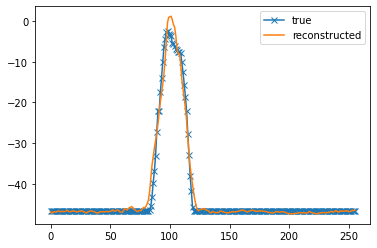

In [87]:
plt.plot(tka[700,65,:],'-x',label='true')
plt.plot(oka[700,65,:],label='reconstructed')
plt.legend()
plt.savefig('example_Ka_singlespec.png',dpi=200,bbox_inches='tight',facecolor='w')

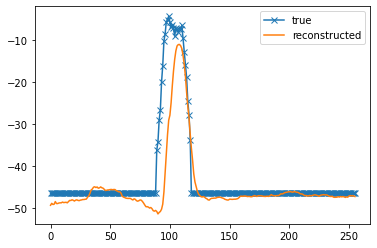

In [88]:
plt.plot(tw[700,65,:],'-x',label='true')
plt.plot(ow[700,65,:],label='reconstructed')
plt.legend()
plt.savefig('example_W_singlespec.png',dpi=200,bbox_inches='tight',facecolor='w')

In [ ]:
ox[noise_mask==1] = np.nan
oka[noise_mask==1] = np.nan
ow[noise_mask==1] = np.nan

#-------------------------------------------------
## compute loss and overlap
#-------------------------------------------------
print('COMPUTE LOSS AND OVERLAP')
loss_x = 0.5 * np.nansum((ox - tx).pow(2))/ (ex.shape[0]*ex.shape[2]*ex.shape[3])
loss_ka = 0.5 * np.nansum((oka - tka).pow(2))/ (ex.shape[0]*ex.shape[2]*ex.shape[3])
loss_w = 0.5 * np.nansum((ow - tw).pow(2))/ (ex.shape[0]*ex.shape[2]*ex.shape[3])
loss = loss_w + loss_x + loss_ka

def overlap(t, o):
    target_remin = t -torch.min(t,axis=-1).values[:,:,None]
    output_remin = (o -torch.min(t,axis=-1).values[:,:,None]).abs()
    otmin = torch.min(target_remin,output_remin)
    rec = .5*(torch.sum(otmin,axis=-1)/torch.sum(output_remin,axis=-1) + torch.sum(otmin,axis=-1)/torch.sum(target_remin,axis=-1))#).mean()
    return rec

recX = np.nanmean(overlap(tx,ox))
recKa = np.nanmean(overlap(tka,oka))
recW = np.nanmean(overlap(tw,ow))

fname = config['directory']+'/loss_'+filespec+'.txt'
with open(fname,'w') as floss:
    floss.write('lossX\t%.4f\n'%loss_x)
    floss.write('lossKa\t%.4f\n'%loss_ka)
    floss.write('lossW\t%.4f\n'%loss_w)
    floss.write('loss\t%.4f\n'%loss)
    floss.write('overlapX\t%.5f\n'%recX)
    floss.write('overlapKa\t%.5f\n'%recKa)
    floss.write('overlapW\t%.5f\n'%recW)
    
with h5py.File(config['model_directory']+'/latent_parameters_attcorr_'+file_spec+'.h5','a+') as f:
    f.create_dataset('recX',overlap(tx,ox).shape,data=overlap(tx,ox))
    f.create_dataset('recW',overlap(tw,ow).shape,data=overlap(tw,ow))


#############################################################################################################
### PLOT RECONSTRUCTED SPECTROGRAMS
#############################################################################################################
if decode:
print('PLOT RECONSTRUCTED SPECTROGRAMS')
i_dataset = 0

fig, axs = plt.subplots(1,2,figsize=(10,3), sharex=True, sharey=True)
axs[0].pcolormesh(np.arange(ex.shape[-1]),np.arange(0,ex.shape[2]),tw[i_dataset],vmin= tw[i_dataset].min()-.05,vmax= tw[i_dataset].max()+.05)
axs[1].pcolormesh(np.arange(ex.shape[-1]),np.arange(0,ex.shape[2]),ow[i_dataset],vmin= tw[i_dataset].min()-.05,vmax= tw[i_dataset].max()+.05)
axs[0].grid()
axs[1].grid()
axs[0].set_title('W spectrogram - True')
axs[1].set_title('W spectrogram - output of NN')
axs[0].set_xlabel('vel bin')
axs[1].set_xlabel('vel bin')
axs[0].set_ylabel('rgate')
fig.savefig(config['directory']+'/ex_spectrogram_W_'+file_spec, bbox_inches='tight', dpi=200)

fig, axs = plt.subplots(1,2,figsize=(10,3), sharex=True, sharey=True)
axs[0].pcolormesh(np.arange(ex.shape[-1]),np.arange(0,ex.shape[2]), tka[i_dataset],vmin= tka[i_dataset].min()-.05,vmax= tka[i_dataset].max()+.05)
axs[1].pcolormesh(np.arange(ex.shape[-1]),np.arange(0,ex.shape[2]), oka[i_dataset],vmin= tka[i_dataset].min()-.05,vmax= tka[i_dataset].max()+.05)
axs[0].grid()
axs[1].grid()
axs[0].set_title('Ka spectrogram - True')
axs[1].set_title('Ka spectrogram - output of NN')
axs[0].set_xlabel('vel bin')
axs[1].set_xlabel('vel bin')
axs[0].set_ylabel('rgate')
fig.savefig(config['directory']+'/ex_spectrogram_Ka_'+file_spec,bbox_inches='tight', dpi=200)

fig, axs = plt.subplots(1,2,figsize=(10,3), sharex=True, sharey=True)
axs[0].pcolormesh(np.arange(ex.shape[-1]),np.arange(0,ex.shape[2]), tx[i_dataset],vmin= tx[i_dataset].min()-.05,vmax= tx[i_dataset].max()+.05)
axs[1].pcolormesh(np.arange(ex.shape[-1]),np.arange(0,ex.shape[2]), ox[i_dataset],vmin= tx[i_dataset].min()-.05,vmax= tx[i_dataset].max()+.05)
axs[0].grid()
axs[1].grid()
axs[0].set_title('X spectrogram - True')
axs[1].set_title('X spectrogram - output of NN')
axs[0].set_xlabel('vel bin')
axs[1].set_xlabel('vel bin')
axs[0].set_ylabel('rgate')
fig.savefig(config['directory']+'/ex_spectrogram_X_'+file_spec,bbox_inches='tight', dpi=200)


i = 50
fig2, axs = plt.subplots(1,3,figsize=(15,3))
axs[0].plot(tx[i_dataset][i], label = 'True')
axs[0].plot(ox[i_dataset][i], label = 'reconstructed')
axs[1].plot(tka[i_dataset][i], label = 'True')
axs[1].plot(oka[i_dataset][i], label='reconstructed')
axs[2].plot(tw[i_dataset][i], label = 'True')
axs[2].plot(ow[i_dataset][i], label='reconstructed')
for ax in axs:
    ax.grid()
    ax.legend()
    ax.set_xlabel('vel bin')
axs[0].set_title('X-band spectrum')
axs[1].set_title('Ka-band spectrum')
axs[2].set_title('W-band spectrum')
fig.savefig(config['directory']+'/ex_overlaid_'+file_spec,bbox_inches='tight', dpi=200)



